# Transient photocurrent

This example shows simulation of transient photocurrent in bulk heterojunction device under pulsed illumination. The effects of trapping are included. Previously published [reference](https://dx.doi.org/10.1063/1.3247547) is reproduced, to demonstrate agreement with known results.

Simulations similar to these shown can be invaluable for interpreting measurements, for which often analytical models do not exist, or have unrealistic assumptions.

In [1]:
%matplotlib inline
import matplotlib.pylab as plt # for plotting
from oedes import *
init_notebook() # fot progress bars
import matplotlib.ticker
formatter=matplotlib.ticker.LogFormatterSciNotation()
plt.rcParams['axes.formatter.use_mathtext']=True

In [2]:
mesh = fvm.mesh1d(220e-9)

## Optical simulation

For electrical simulation, absorption profile is needed. The calculation uses complex optical constants of materials taken from the reference.

In [3]:
from oedes.optical import *
from oedes.optical import test_materials
from oedes.optical.spectra import GaussianSpectrum
active_layer = IsotropicLayer(mesh.length, Material(ConstFunctionOfWavelength(1.75 + 0.49j)))
layers = [
   IsotropicLayer(1e-3,test_materials.Glass),
    IsotropicLayer(140e-9,test_materials.ITO),
    IsotropicLayer(40e-9,test_materials.PEDOT_PSS),    
    active_layer,
    IsotropicLayer(100e-9,test_materials.Al)
]
light = GaussianSpectrum(1., 525e-9,0.1e-9)
optical_model=NormalIncidence(layers, light, light.xdata)
x=np.linspace(0,active_layer.thickness)

In [4]:
# This handles convention in the paper: normalization to 1, and reversed x axis.
optical_model_of_active_layer = optical_model.in_layer(active_layer, x)
generation_data = optical_model_of_active_layer.photons_absorbed()
generation_profile = optical_model_of_active_layer.interpolated(generation_data/generation_data[0])
A = lambda x:generation_profile(active_layer.thickness - x)

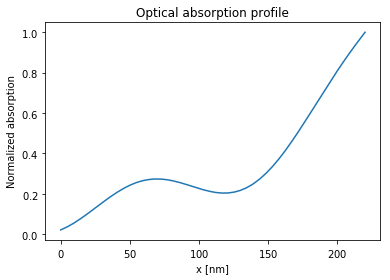

In [5]:
x = mesh.cells['center']
plt.plot(x * 1e9, A(x))
testing.store(x)
testing.store(A(x))
plt.xlabel('x [nm]')
plt.ylabel('Normalized absorption');
plt.title('Optical absorption profile');

## Electrical simulation

Model consists in Poisson's equation, coupled to hole and electron transport equation. Additionally, excitons and trapped eletrons are modeled. It is assumed that transport of holes and electrons is described by Frenkel-Poole model. Excitons and trapped electrons and not transported.

In [6]:
thermal = models.ConstTemperature()
poisson = models.Poisson(mesh)
poisson.bc = [models.AppliedVoltage(k) for k in mesh.boundaries]
electron = models.BandTransport(poisson=poisson,thermal=thermal,name='electron',z=-1,mobility_model=models.FrenkelPooleMobility())
hole = models.BandTransport(poisson=poisson,thermal=thermal,name='hole',z=1,mobility_model=models.FrenkelPooleMobility())
for eq in [ electron, hole ]:
    eq.bc = [models.FermiLevelEqualElectrode(boundary) for boundary in mesh.boundaries]

Trapped electrons are coupled to mobile electrons by equation : 

$\frac{dn_t}{dt}=C_t (N_t-n_t) n - C_{dt} N_0 N_t$

where rates $C_t$ is defined by `params['electron.trap0.trate']` and $C_{dt}$ by `params['electron.trap0.rrate']`. Total densities of states $N_t$, $N_0$ are defined by `params['electron.trap0.N0']` and `params['electron.N0']`.

In [7]:
electrontrap0 = models.NontransportedSpecies(poisson=poisson, name='electron.trap0', z=-1)
trapping = models.TrapSource(electron, electrontrap0, fill_transport=False, rrate_param=True)

Absorbed light creates excitons according to the previously calculated normalized absorption profile `A`, with prefactor $1.63\times10^{26}$.

In [8]:
exciton = models.NontransportedSpecies(poisson=poisson, name='exciton',z=0)
def gen(x):
    G0 = 1.63e26
    return G0 * A(x)
generation = models.SimpleGenerationTerm(exciton, gen)

Excitons dissociate according to Onsager-Braun model, and also can decay without creating mobile charges.

In [9]:
decay = models.SimpleDecayTerm(exciton)
recombination_dissociation = models.OnsagerBraunRecombinationDissociationTerm(
        exciton, electron, hole)

Finalize the model:

In [10]:
current_calculation = models.RamoShockleyCurrentCalculation([poisson])
equations = [ thermal, poisson, electron, hole, electrontrap0, trapping, exciton, generation, decay, recombination_dissociation, current_calculation ]

In [11]:
model = models.CompositeModel(equations)
model.setUp()

Default parameters are specified below:

In [12]:
N0 = 1e27
default_params = {
    'T': 300.,
    'epsilon_r': 3.,
    
    # Frenkel-Poole mobilities
    'electron.mu0': 9.9e-8,
    'hole.mu0': 1.8e-8,
    'electron.gamma': 1.5e-5,
    'hole.gamma': -2.2e-4,
    
    # Onsager-Braun model
    'exciton.distance': 2.8e-9,
    'exciton.decay': 1.3e7,
    
    # Kinetics of trapping
    'electron.trap0.N0': 1.3e22,
    'electron.trap0.trate': 2.5e-16,
    'electron.trap0.rrate': 1e4 / N0,
    
    # Illumination
    'exciton.generation.I': 1.,
    
    # Electrode workfunctions/bandgap/DOS
    'electron.N0': N0,
    'hole.N0': N0,
    'electron.energy': 0.,
    'electrode0.workfunction': 0.5,
    'hole.energy': -1.9,
    'electrode1.workfunction': 1.4,
    'npi': 0.,
    
    # Applied voltage
    'electrode0.voltage': 0.,
    'electrode1.voltage': 0.,
}

Simulation procedure is defined below. Firstly, steady-state is simulated for device without illumination. It serves as the initial conditions. The prevent recalculations, the solution is stored globally in `cic`. Then, the light intensity is set to nonzero and transient simulation is performed for time `t`. After that, light illumination parameter is set to 0 and transient relaxation is simulated.

In [13]:
cic = context(model)

def run(I, p={}, t=100e-6, store=True):
    params = dict(default_params)
    params.update(p)
    params['exciton.generation.I'] = 0.
    cic.solve(params)
    c = context(model, x=cic.x)
    params['exciton.generation.I'] = I
    c.transient(dict(params), 1. * t, 1e-9)
    params['exciton.generation.I'] = 0.
    c.transient(dict(params), 5. * t, 1e-9)
    t, j = c.teval('time', 'J')
    if store:
        # automatic testing support
        testing.store(t, atol=1e-12)
        testing.store(j, atol=1e-12)
    return c, t, j

## Results

### Simulations varying light intensity

The plots below are for varying light intensity, given in the legend. The second plot shows the same signal as the first one, but it is normalized to the steady-state value of current under illumination. The same normalization is used in the third plots, which shows the decay.

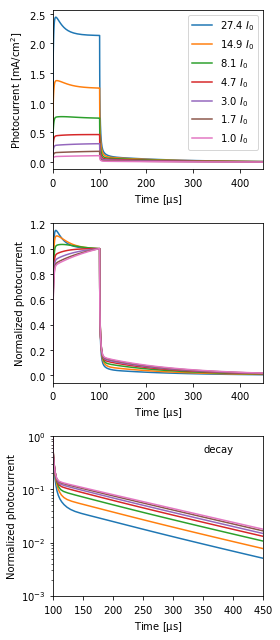

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(4, 9))
for I in progressbar([1., 1.7, 3., 4.7, 8.1, 14.9, 27.4][::-1],'I'):
    c, t, j = run(I)
    ax1.plot(t * 1e6, j * 0.1, label='%.1f $I_0$' % I)
    jn = c.attime(99e-6).output()['J']
    ax2.plot(t * 1e6, j / jn)
    ax3.plot(t * 1e6, j / jn)
ax3.set_yscale('log')
for a in [ax1, ax2, ax3]:
    a.set_xlabel(r'Time [$\mathrm{\mu s}$]')
    a.set_xlim([0, 450])
for a in [ax1]:
    a.set_ylabel(r'Photocurrent [$\mathrm{mA/cm^2}$]')
for a in [ax2, ax3]:
    a.set_ylabel('Normalized photocurrent')
ax3.set_ylim([1e-3, 1])
ax3.set_xlim([100, 450])
ax3.text(350,0.5,'decay')
ax1.legend(loc='upper right')
fig.tight_layout();

### Decay of photocurrent: influence of trap density

The plot below shows the decay of photocurrent, in function of trap density $N_t$.

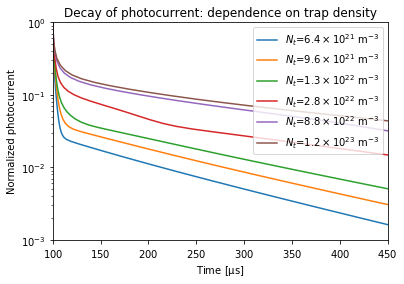

In [15]:
ax = plt.gca()
for Nt in progressbar([6.4e21, 9.6e21, 1.3e22, 2.8e22, 8.8e22, 1.2e23],'Nt'):
    c, t, j = run(27.4, {'electron.trap0.N0': Nt})
    jn = c.attime(99e-6).output()['J']
    ax.plot(t * 1e6, j / jn, label=r'$N_t$=%s $\mathrm{m^{-3}}$' % formatter(Nt))
ax.set_xlabel(r'Time [$\mathrm{\mu s}$]')
ax.set_ylabel('Normalized photocurrent')
ax.set_ylim([1e-3, 1])
ax.set_xlim([100, 450])
ax.set_yscale('log')
ax.set_title('Decay of photocurrent: dependence on trap density')
ax.legend(loc='upper right');

### Decay of photocurrent: influence of detrapping rate

The plot below shows the decay of photocurrent, calculated for different values of detrapping rate $C_{dt}$.

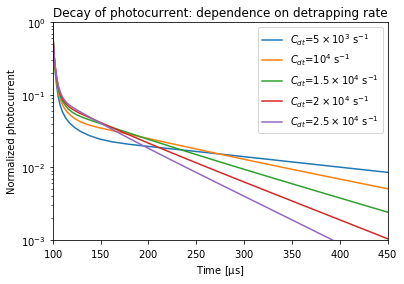

In [16]:
ax = plt.gca()
Nt = 1.2e23
for Cdt in progressbar([5e3, 1e4, 1.5e4, 2e4, 2.5e4],'Cdt'):
    c, t, j = run(27.4, {'electron.trap0.rrate': Cdt / N0})
    jn = c.attime(99e-6).output()['J']
    ax.plot(t * 1e6, j / jn, label=r'$C_{dt}$=%s $\mathrm{s^{-1}}$' % formatter(Cdt))
ax.set_xlabel(r'Time [$\mathrm{\mu s}$]')
ax.set_ylabel('Normalized photocurrent')
ax.set_ylim([1e-3, 1])
ax.set_xlim([100, 450])
ax.set_yscale('log');
ax.set_title('Decay of photocurrent: dependence on detrapping rate')
ax.legend(loc='upper right');

### Rise of photocurrent: influence of trapping rate

The plot below shows the rise of photocurrent, calculated for different values of trapping rate $C_t$.

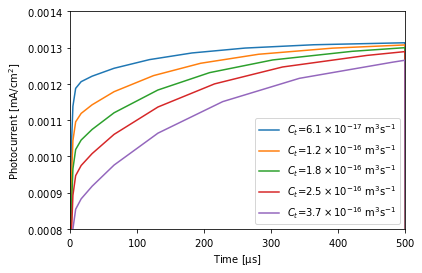

In [17]:
ax = plt.gca()
for Ct in progressbar([6.1e-17, 1.2e-16, 1.8e-16, 2.5e-16, 3.7e-16],'Ct'):
    c, t, j = run(1e-2, {'electron.trap0.trate': Ct}, t=500e-6)
    ax.plot(t * 1e6, j * 0.1, label=r'$C_{t}$=%s $\mathrm{m^3 s^{-1}}$' % formatter(Ct))
ax.set_xlabel(r'Time [$\mathrm{\mu s}$]')
ax.set_ylabel(r'Photocurrent [$\mathrm{mA/cm^2}$]')
ax.set_ylim([0.8e-3, 1.4e-3])
ax.set_xlim([0, 500])
ax.legend(loc='lower right');

### Rise of photocurrent: influence of detrapping rate

The plot below shows the rise of photocurrent, calculated for different values of trapping rate $C_{dt}$.

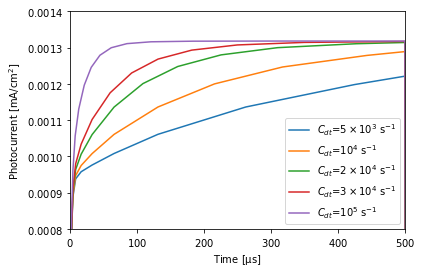

In [18]:
ax = plt.gca()
for Cdt in progressbar([5e3, 1e4, 2e4, 3e4, 1e5],'Cdt'):
    c, t, j = run(1e-2, {'electron.trap0.rrate': Cdt / N0}, t=500e-6)
    ax.plot(t * 1e6, j * 0.1, label=r'$C_{dt}$=%s $\mathrm{s^{-1}}$' % formatter(Cdt))
ax.set_xlabel(r'Time [$\mathrm{\mu s}$]')
ax.set_ylabel(r'Photocurrent [$\mathrm{mA/cm^2}$]')
ax.set_ylim([0.8e-3, 1.4e-3])
ax.set_xlim([0, 500])
ax.legend(loc='lower right');

### Rise of photocurrent: influence of trap density

The plot below shows the rise of photocurrent, calculated for different values of trap density $N_t$.

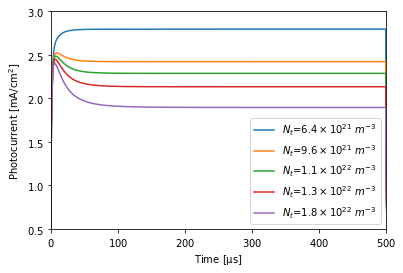

In [19]:
ax = plt.gca()
for Nt in progressbar([6.4e21, 9.6e21, 1.1e22, 1.3e22, 1.8e22],'Nt'):
    c, t, j = run(27.4, {'electron.trap0.N0': Nt,
                         'electron.trap0.trate': 3.2e6 / Nt}, t=500e-6)
    ax.plot(t * 1e6, j * 0.1, label=r'$N_t$=%s $m^{-3}$' % formatter(Nt))
ax.set_xlabel(r'Time [$\mathrm{\mu s}$]')
ax.set_ylabel(r'Photocurrent [$\mathrm{mA/cm^2}$]')
ax.set_ylim([0.5, 3])
ax.set_xlim([0, 500])
ax.legend(loc='lower right');

### Rise of photocurrent: constant trap depth

Plot plot below shows the rise of photocurrent calculated for different values of trapping / detrapping rates. Their ratio is kept fixed to simulated constant trap depth.

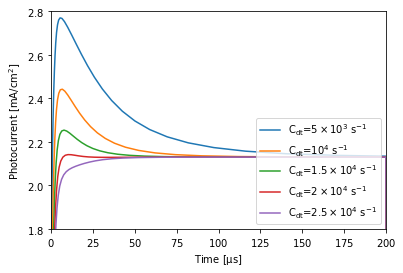

In [20]:
ax = plt.gca()
for Cdt in progressbar([5e3, 1e4, 1.5e4, 2e4, 2.5e4],'Cdt'):
    c, t, j = run(27.4, {'electron.trap0.rrate': Cdt / N0,
                         'electron.trap0.trate': 2.5e-16 / 1e4 * Cdt}, t=200e-6)
    ax.plot(t * 1e6, j * 0.1, label=r'$\mathrm{C_{dt}}$=%s $\mathrm{s^{-1}}$' % formatter(Cdt))
ax.set_xlabel(r'Time [$\mathrm{\mu s}$]')
ax.set_ylabel(r'Photocurrent [$\mathrm{mA/cm^2}$]')
ax.set_ylim([1.8, 2.8])
ax.set_xlim([0, 200])
ax.legend(loc='lower right');

### Profiles of charge carrier densities, electric field, and recombination

Below, profiles are shown for device illuminated with $I=27.4I_0$. $x$ denotes the position inside the device.

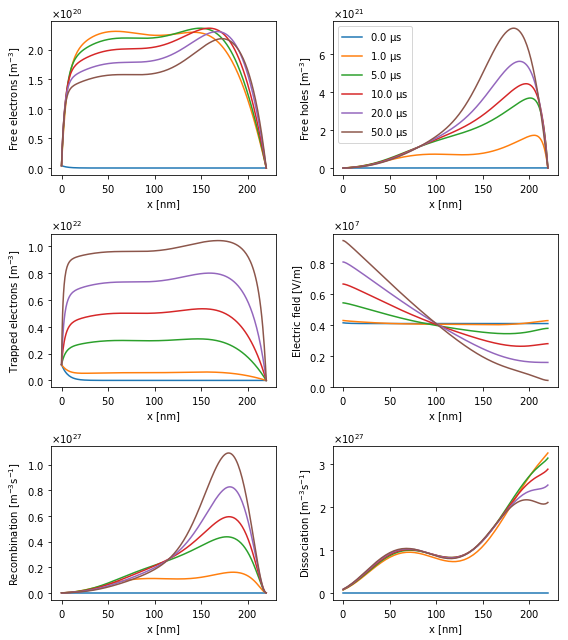

In [21]:
r = []
fig, ((nf, pf), (nt, e), (r, d)) = plt.subplots(3, 2, figsize=(8, 9))
c = run(27.4, store=False)[0]
for t in [0e-6, 1e-6, 5e-6, 10e-6, 20e-6, 50e-6]:
    o = c.attime(t).output()

    def _p(ax, y, x=mesh.cells['center']):
        testing.store(y, rtol=1e-4)
        ax.plot(x * 1e9, y, label=r'%.1f $\mathrm{\mu s}$' % (t * 1e6))
    _p(nt, o['electron.trap0.c'])
    _p(nf, o['electron.c'])
    _p(pf, o['hole.c'])
    _p(e, o['E'], x=mesh.faces['center'])
    _p(r, o['exciton.dissociation.recombination'])
    _p(d, o['exciton.dissociation.dissociation'])
nt.set_ylabel(r'Trapped electrons [$\mathrm{m^{-3}}$]')
nf.set_ylabel(r'Free electrons [$\mathrm{m^{-3}}$]')
pf.set_ylabel(r'Free holes [$\mathrm{m^{-3}}$]')
e.set_ylabel(r'Electric field [$\mathrm{V/m}$]')
r.set_ylabel(r'Recombination [$\mathrm{m^{-3} s^{-1}}$]')
d.set_ylabel(r'Dissociation [$\mathrm{m^{-3} s^{-1}}$]')
pf.legend(loc='upper left')
for a in [nf, pf, nt, e, r, d]:
    a.set_xlabel('x [nm]')
plt.tight_layout();

## Reference

Inchan Hwang, Christopher R. McNeill, Neil C. Greenham [Drift-diffusion modeling of photocurrent transients in bulk heterojunction solar cells](https://dx.doi.org/10.1063/1.3247547), J Appl Phys 106, 094506 (2009).


---
This file is a part of __oedes__, an open source organic electronic device 
simulator. For more information, see <https://www.github.com/mzszym/oedes>.
